# Proyecto IA - Aprendizaje por Refuerzo
---

## Integrantes
- Andrés Francisco García Rivero
- Jorge Muñoz Rodríguez

### 0.- Funciones comunes

In [240]:
import numpy as np
import mdptoolbox.mdp as mdp
import matplotlib.pyplot as plt

In [241]:
def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz),(int(numeros[0]),int(numeros[1]))

In [242]:
def parsea_politica_ql(ql):
    return [nav_acciones[i] for i in ql.policy]

In [243]:
def visualiza_mapa():
    plt.figure(figsize=(len(mapa[0]), len(mapa)))
    plt.imshow(1-mapa, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa[0]) - 0.5)
    plt.ylim(-0.5, len(mapa) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'blue', facecolor = 'blue'))

In [244]:
# Verificar si hay colisión
def hay_colision(estado):
    return mapa[estado[1],estado[0]] == 1

# Definir los movimientos posibles
def aplica_accion(estado, accion):
    if hay_colision(estado):
        return estado
    x = estado[0] + movimientos[accion][0]
    y = estado[1] + movimientos[accion][1]
    if x < 1 or x >= mapa.shape[1]-1 or y < 1 or y >= mapa.shape[0]-1 or hay_colision((x, y)):
        return estado
    return x, y

In [245]:
K1 = -1000
K2 = -10000

def obtiene_recompensa_simple(estado):
    if hay_colision(estado):
        valor = K1
    else:
        valor = - np.sqrt( (estado[0]-destino[0])**2 + (estado[1]-destino[1])**2)*0.5
    return valor

def obtiene_recompensa(estado, accion):
    nuevo_estado = aplica_accion(estado, accion)
    if hay_colision(nuevo_estado):
        return K2
    if accion == 'wait' and estado != destino:
        return K1
    return -np.sqrt((nuevo_estado[0] - destino[0])**2 + (nuevo_estado[1] - destino[1])**2)*0.5

In [246]:
movimientos = {
    'wait': (0, 0), 'N': (0, 1), 'NE': (1, 1), 'E': (1, 0),
    'SE': (1, -1), 'S': (0, -1), 'SO': (-1, -1), 'O': (-1, 0), 'NO': (-1, 1)
}
nav_estados = [(i, j) for i in range(n) for j in range(m)]
nav_acciones = ['wait','N','NE','E','SE','S','SO','O','NO']

In [247]:
def visualiza_politica(politica):
    visualiza_mapa()
    for p in zip(nav_estados,politica):
        accion = p[1]
        if accion=='wait':
            # Si no está en un obstaculo, escribimos la política
            if not hay_colision(p[0]):
                plt.text(p[0][0],p[0][1],'WAIT',fontsize=40,ha='center',va='center', color='red', fontweight='bold')
            continue
        estado = p[0]
        e1 = aplica_accion(estado,accion)
        x0 = estado[0]
        y0 = estado[1]
        x1 = e1[0]
        y1 = e1[1]
        
        plt.gca().arrow(x0, y0, (x1 - x0)*0.6, (y1 - y0)*0.6,
         head_width=0.3, head_length=0.3, fc='black', ec='black')

In [248]:
def visualiza_recompensas():
    visualiza_mapa()
    recompensas = [obtiene_recompensa_simple(e) for e in nav_estados]
    recompensas = [np.nan if elemento == K1 else elemento for elemento in recompensas]
    max_recompensa = np.nanmax(recompensas)
    min_recompensa = np.nanmin(recompensas)
    for e in nav_estados:
        r = obtiene_recompensa_simple(e)
        if r == K1:
            continue
        a = (r-min_recompensa)/(max_recompensa-min_recompensa)
        rect = plt.Rectangle((e[0] - 0.5, e[1] - 0.5), 1, 1, alpha = a,linewidth=1, edgecolor='blue', facecolor='blue')
        plt.gca().add_patch(rect)

In [249]:
# Método para visualizar el mapa con la política óptima
def visualiza_politica_letras(politica, mapa, destino):
    plt.figure(figsize=(20, 20))
    plt.imshow(1 - mapa, cmap='gray', origin='lower')

    # Dibujar el destino y la posición inicial con las coordenadas ajustadas si es necesario
    plt.gca().add_patch(plt.Circle(destino, radius=0.3, edgecolor='red', facecolor='red', label='Destino'))

    # Dibujar las políticas
    for i in range(n):
        for j in range(m):
            if mapa[j, i] == 0:  # Ajuste a la indexación correcta si es necesario
                s_index = i * m + j
                accion = nav_acciones[politica[s_index]]
                if accion == 'wait':
                    print(f"Esperar en {i, j}")
                    plt.text(i, j, 'WAIT', ha='center', va='center', color='blue', fontsize=12)
                else:
                    plt.text(i, j, accion, ha='center', va='center', color='brown', fontsize=12)

    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Destino'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Wait'),
    ])
    plt.show()

### Apartado 1: Implementación mediante Q-Learning

Mapa de tamaño 15 filas x 51 columnas


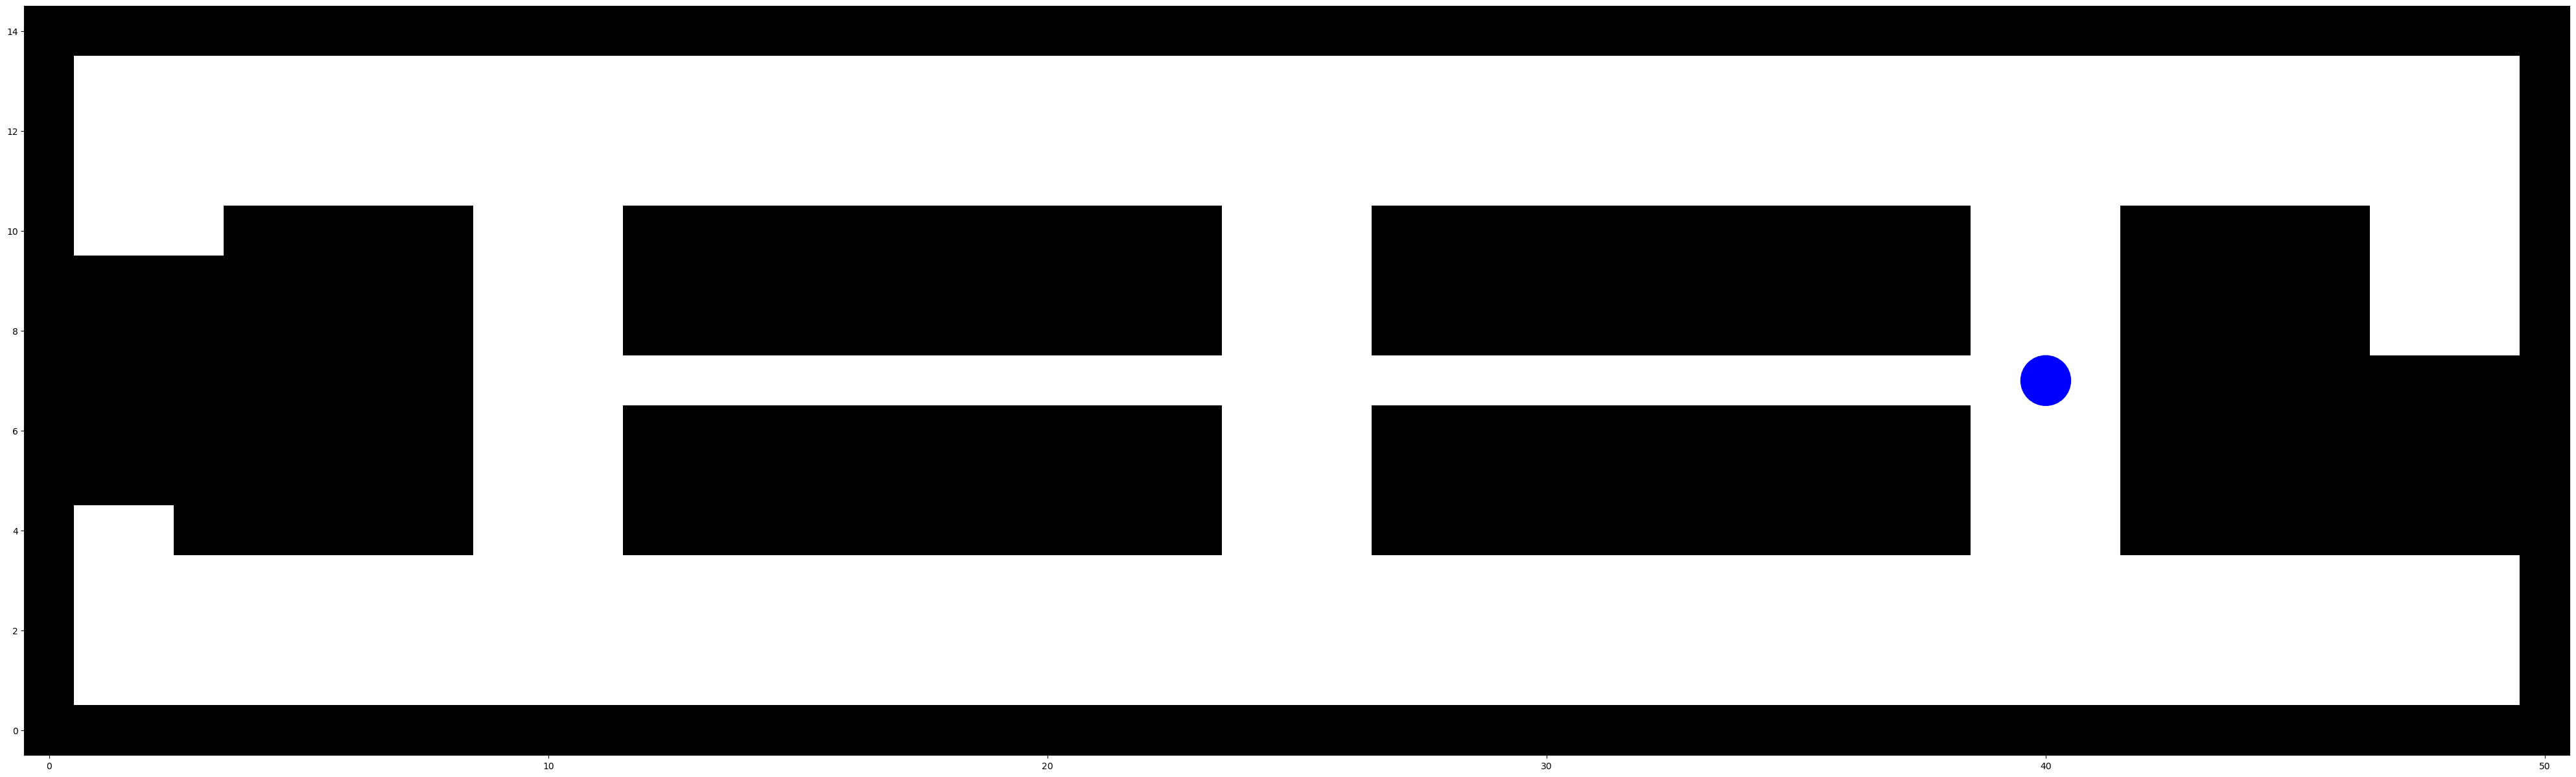

In [250]:
mapa,destino = lee_mapa("map.txt")
m,n = mapa.shape
Perror = 0.1  # Probabilidad de error en el movimiento
print("Mapa de tamaño",m,"filas x",n,"columnas")
visualiza_mapa()

In [251]:
def crea_recompensas_sistema():
    matriz = []
    for e in nav_estados:
        fila = [obtiene_recompensa(e, accion) for accion in nav_acciones]
        matriz.append(fila)
    return np.array(matriz)

nav_recompensas_sistema = crea_recompensas_sistema()

In [252]:
def obtiene_indice_estado(estado):
    return int(estado[0]*mapa.shape[0]+estado[1])

In [253]:
def obtiene_posibles_errores(accion):
    errores_dict = {
        'N': ['NE', 'NO'], 'S': ['SE', 'SO'], 'E': ['NE', 'SE'], 'O': ['NO', 'SO'],
        'NE': ['N', 'E'], 'NO': ['N', 'O'], 'SE': ['S', 'E'], 'SO': ['S', 'O']
    }
    return errores_dict.get(accion, [])

In [254]:
def crea_transiciones_movimiento(accion, prob_error):
    matriz = []
    for e0 in nav_estados:
        fila = [0] * len(nav_estados)
        if hay_colision(e0):
            fila[obtiene_indice_estado(e0)] = 1
        else:
            goal = aplica_accion(e0, accion)
            if prob_error == 0:
                fila[obtiene_indice_estado(goal)] = 1
            else:
                errores = obtiene_posibles_errores(accion)
                fila[obtiene_indice_estado(goal)] = 1 - prob_error
                for error in errores:
                    goal_error = aplica_accion(e0, error)
                    fila[obtiene_indice_estado(goal_error)] += prob_error / len(errores)
        suma_fila = sum(fila)
        if suma_fila != 1:
            fila = [x / suma_fila for x in fila]
        matriz.append(fila)
    return np.array(matriz)


In [255]:
def crea_transiciones_sistema(prob_error):
    return np.array([crea_transiciones_movimiento(accion, prob_error) for accion in nav_acciones])

nav_transiciones_sistema = crea_transiciones_sistema(Perror)

In [256]:
# Implementación de Q-Learning con mdptoolbox
# ql = mdp.QLearning(nav_transiciones_sistema, nav_recompensas_sistema, discount=0.10, n_iter=100000)
# ql.run()
# politica_ql = parsea_politica_ql(ql)

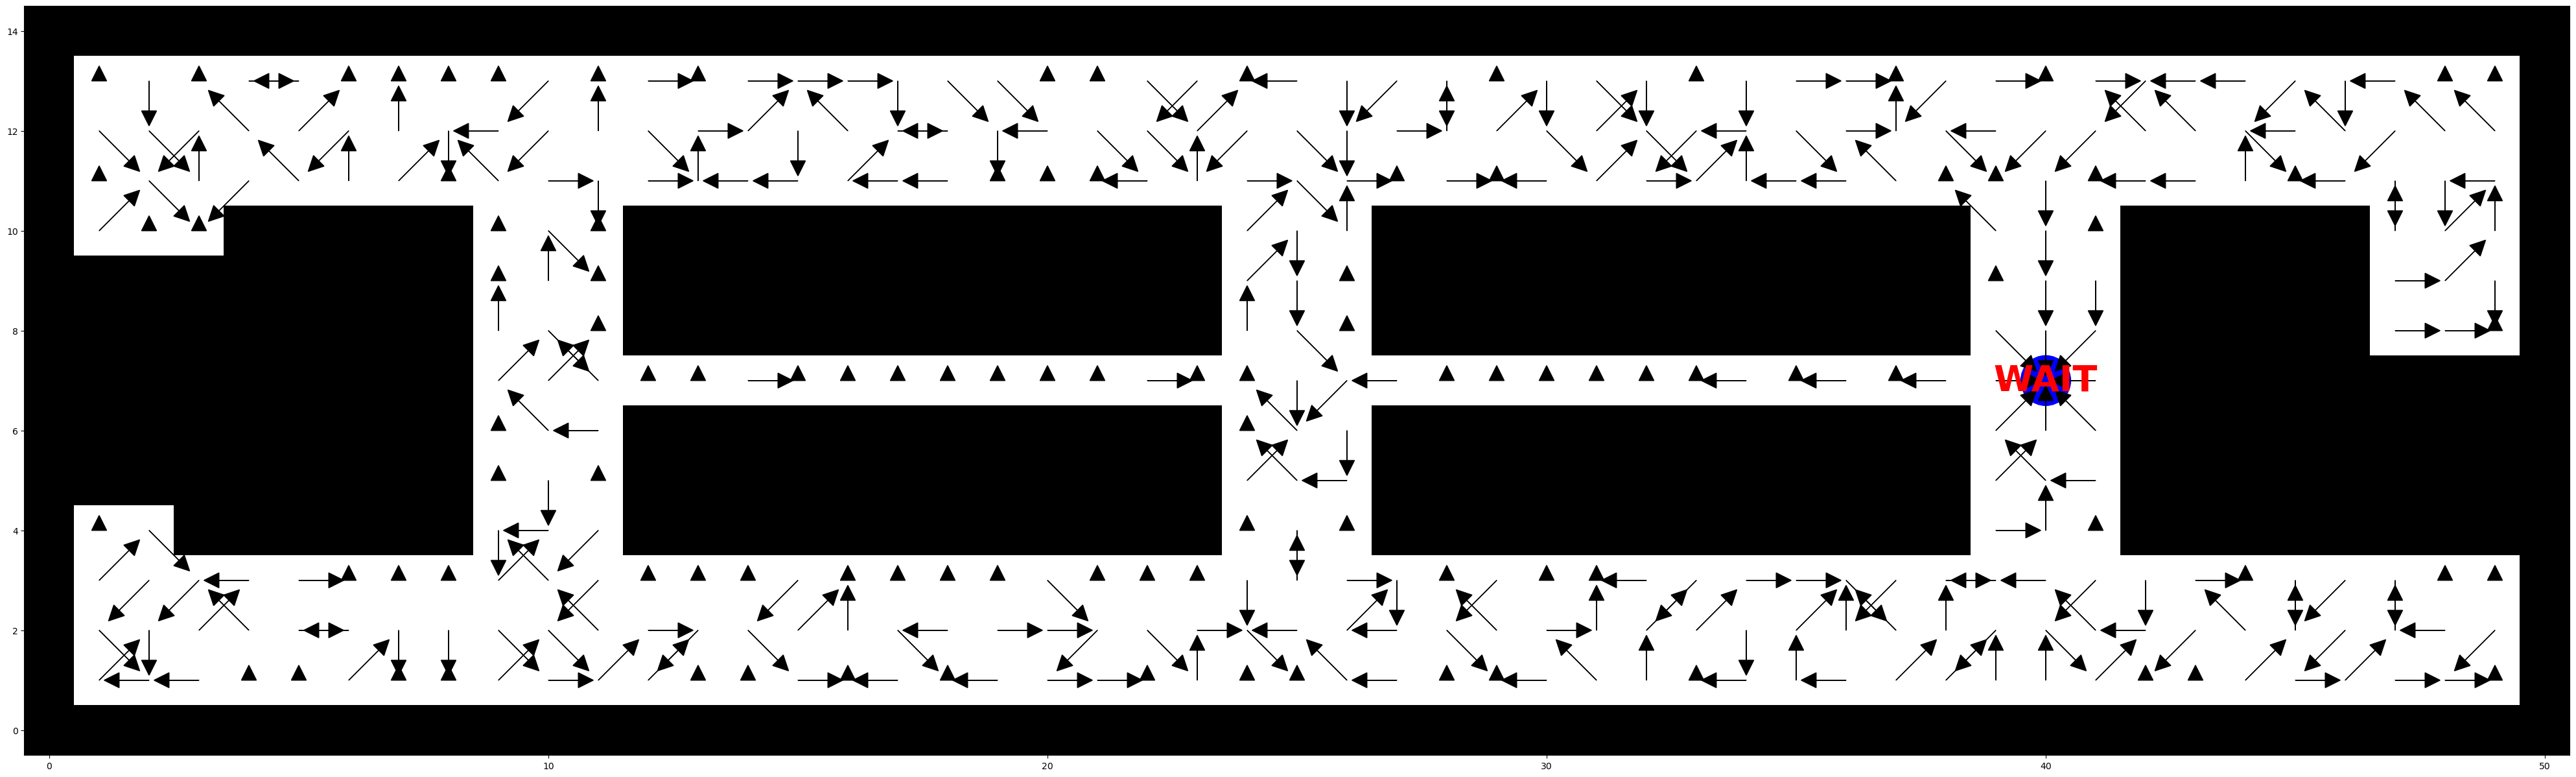

In [257]:
visualiza_politica(politica_ql)

### Apartado 2: Implementación mediante Montecarlo

In [258]:
# Política Epsilon-Greedy
def crea_politica_greedy():
    p = []
    for e in nav_estados:
        valores = []
        for a in nav_acciones:
            e1 = aplica_accion(e,a)
            valores.append(obtiene_recompensa_simple(e1))
        accion = nav_acciones[np.argmax(valores)]
        p.append(accion)
    return p
politica_greedy = crea_politica_greedy()


In [259]:
def greedy_policy(state, Q):
    # Selecciona la acción con el máximo valor Q para el estado dado
    return max(Q[state], key=Q[state].get)

In [260]:
# Función Monte Carlo
def monte_carlo(mapa, destino, num_episodes, gamma=0.95):
    Q = {estado: {accion: 0 for accion in nav_acciones} for estado in nav_estados}
    N = {estado: {accion: 0 for accion in nav_acciones} for estado in nav_estados}
    
    for _ in range(num_episodes):
        estado = inicializa_posicion(mapa, destino)
        episodio = []
        while len(episodio) < 1000:
            accion = greedy_policy(estado, Q)
            nuevo_estado = aplica_accion(estado, accion)
            recompensa = obtiene_recompensa(estado, accion)
            episodio.append((estado, accion, recompensa))
            if nuevo_estado == destino or accion == 'wait':
                break
            estado = nuevo_estado

        G = 0
        for estado, accion, recompensa in reversed(episodio):
            G = gamma * G + recompensa
            N[estado][accion] += 1
            Q[estado][accion] = ((N[estado][accion] - 1) * Q[estado][accion] + G) / N[estado][accion]

    # Extraer la política óptima
    politica_optima = [max(Q[estado], key=Q[estado].get) for estado in nav_estados]
    return politica_optima


In [261]:
# mc = monte_carlo(mapa, destino, 5000)

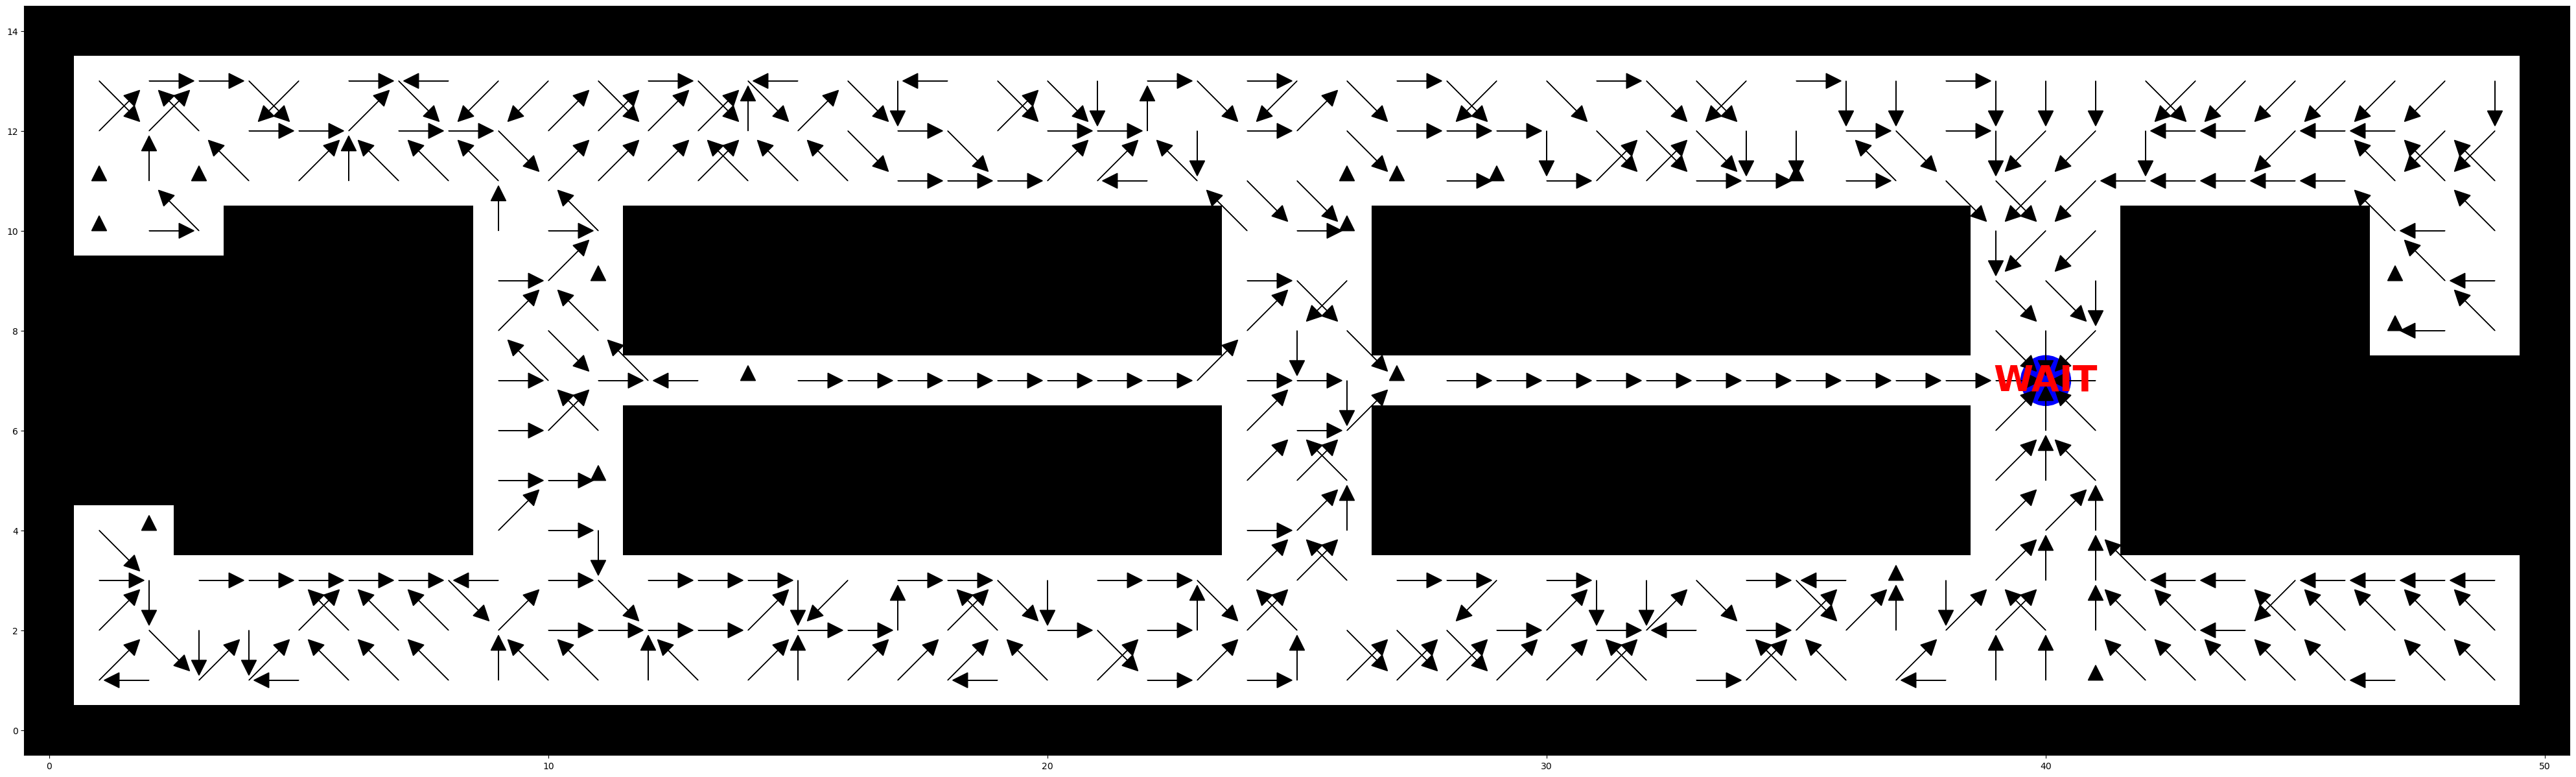

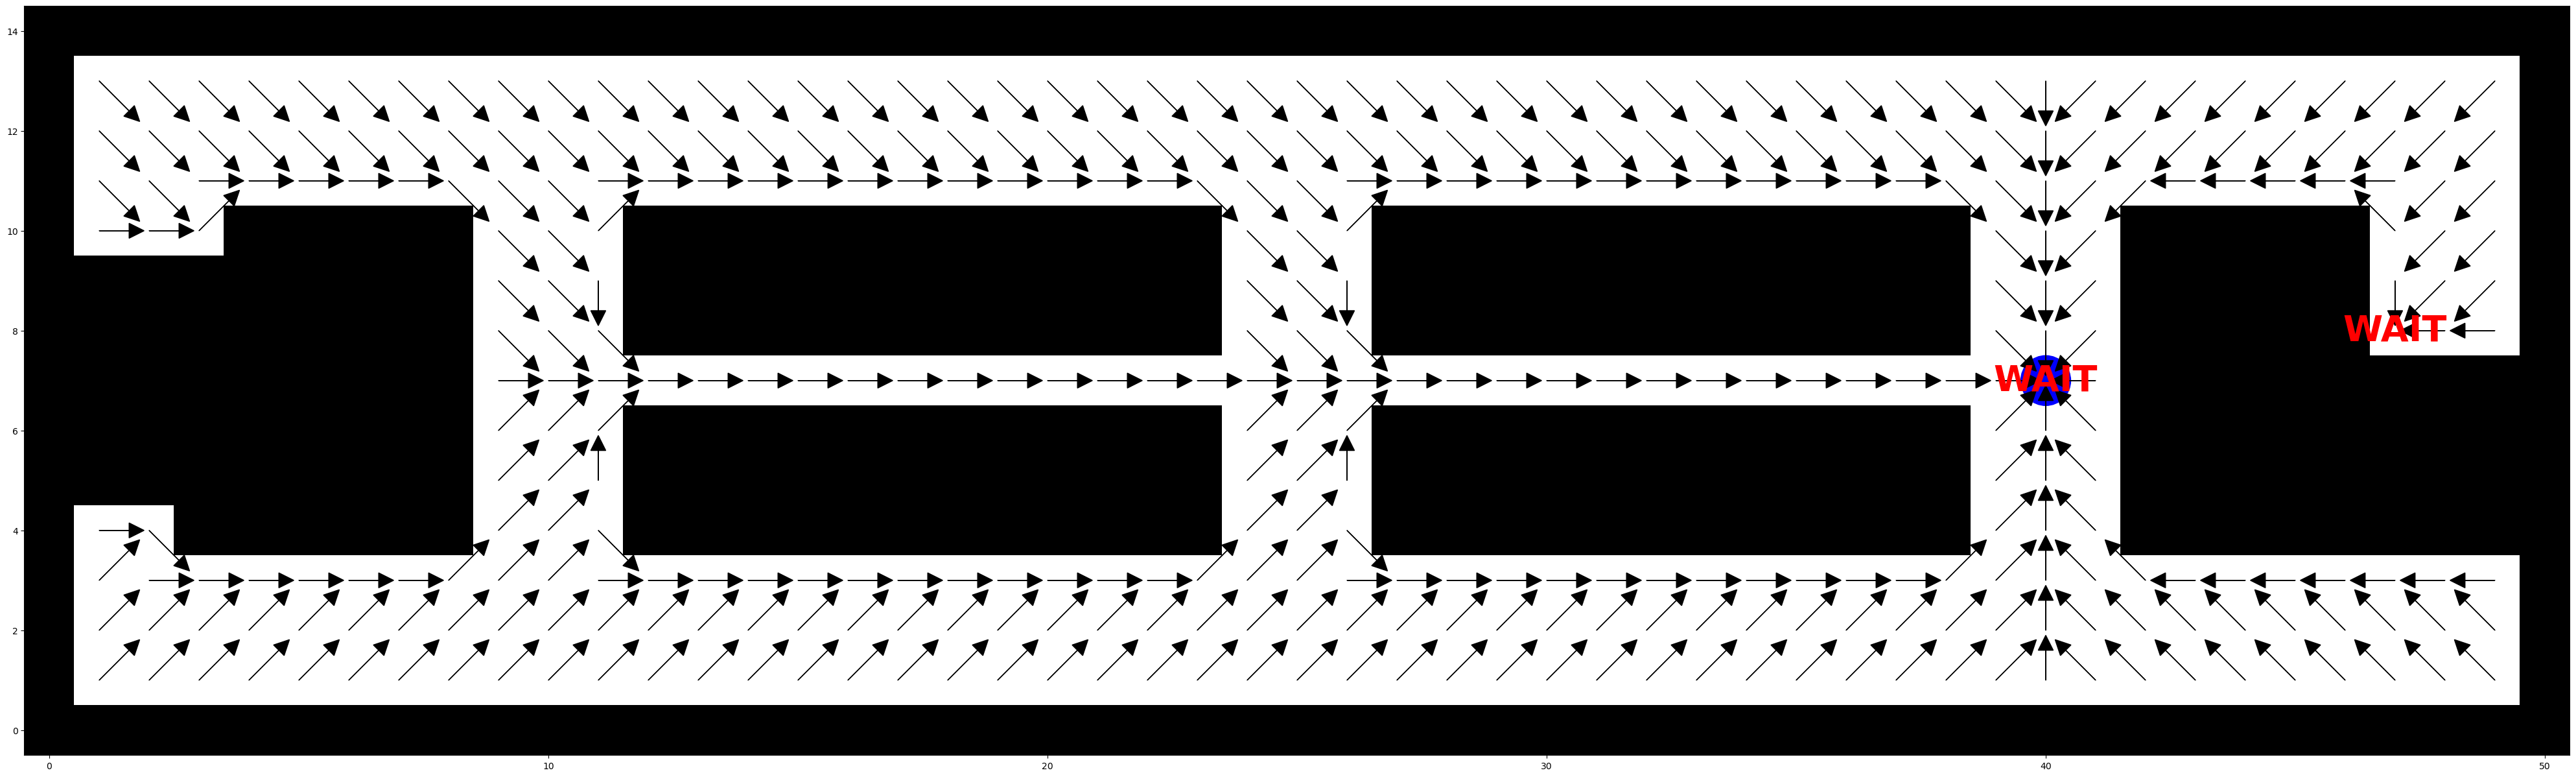

In [262]:
visualiza_politica(mc)
visualiza_politica(politica_greedy)

### Apartado 3: Implementación mediante SARSA (State-Action-Reward-State-Action)

In [263]:
def epsilon_greedy_policy(state, Q):
    """ Selección de acciones usando la política epsilon-greedy. """
    if random.random() < epsilon:
        return random.choice(nav_acciones)
    else:
        return max(Q[state], key=Q[state].get)

def sarsa(mapa, destino, num_episodes, max_steps=100, alpha=0.1, gamma=0.95, epsilon=0.1):
    Q = {estado: {accion: 0 for accion in nav_acciones} for estado in nav_estados}
    for episode in range(num_episodes):
        estado = inicializa_posicion(mapa, destino)
        accion = epsilon_greedy_policy(estado, Q)
        
        for _ in range(max_steps):
            nuevo_estado = aplica_accion(estado, accion)
            recompensa = obtiene_recompensa(estado, accion)
            nueva_accion = epsilon_greedy_policy(nuevo_estado, Q)
            
            # Actualización SARSA
            Q[estado][accion] += alpha * (recompensa + gamma * Q[nuevo_estado][nueva_accion] - Q[estado][accion])
            
            estado, accion = nuevo_estado, nueva_accion
            
            if nuevo_estado == destino or accion == 'wait':
                break
    
    politica_optima = [max(Q[estado], key=Q[estado].get) for estado in nav_estados]

    return politica_optima



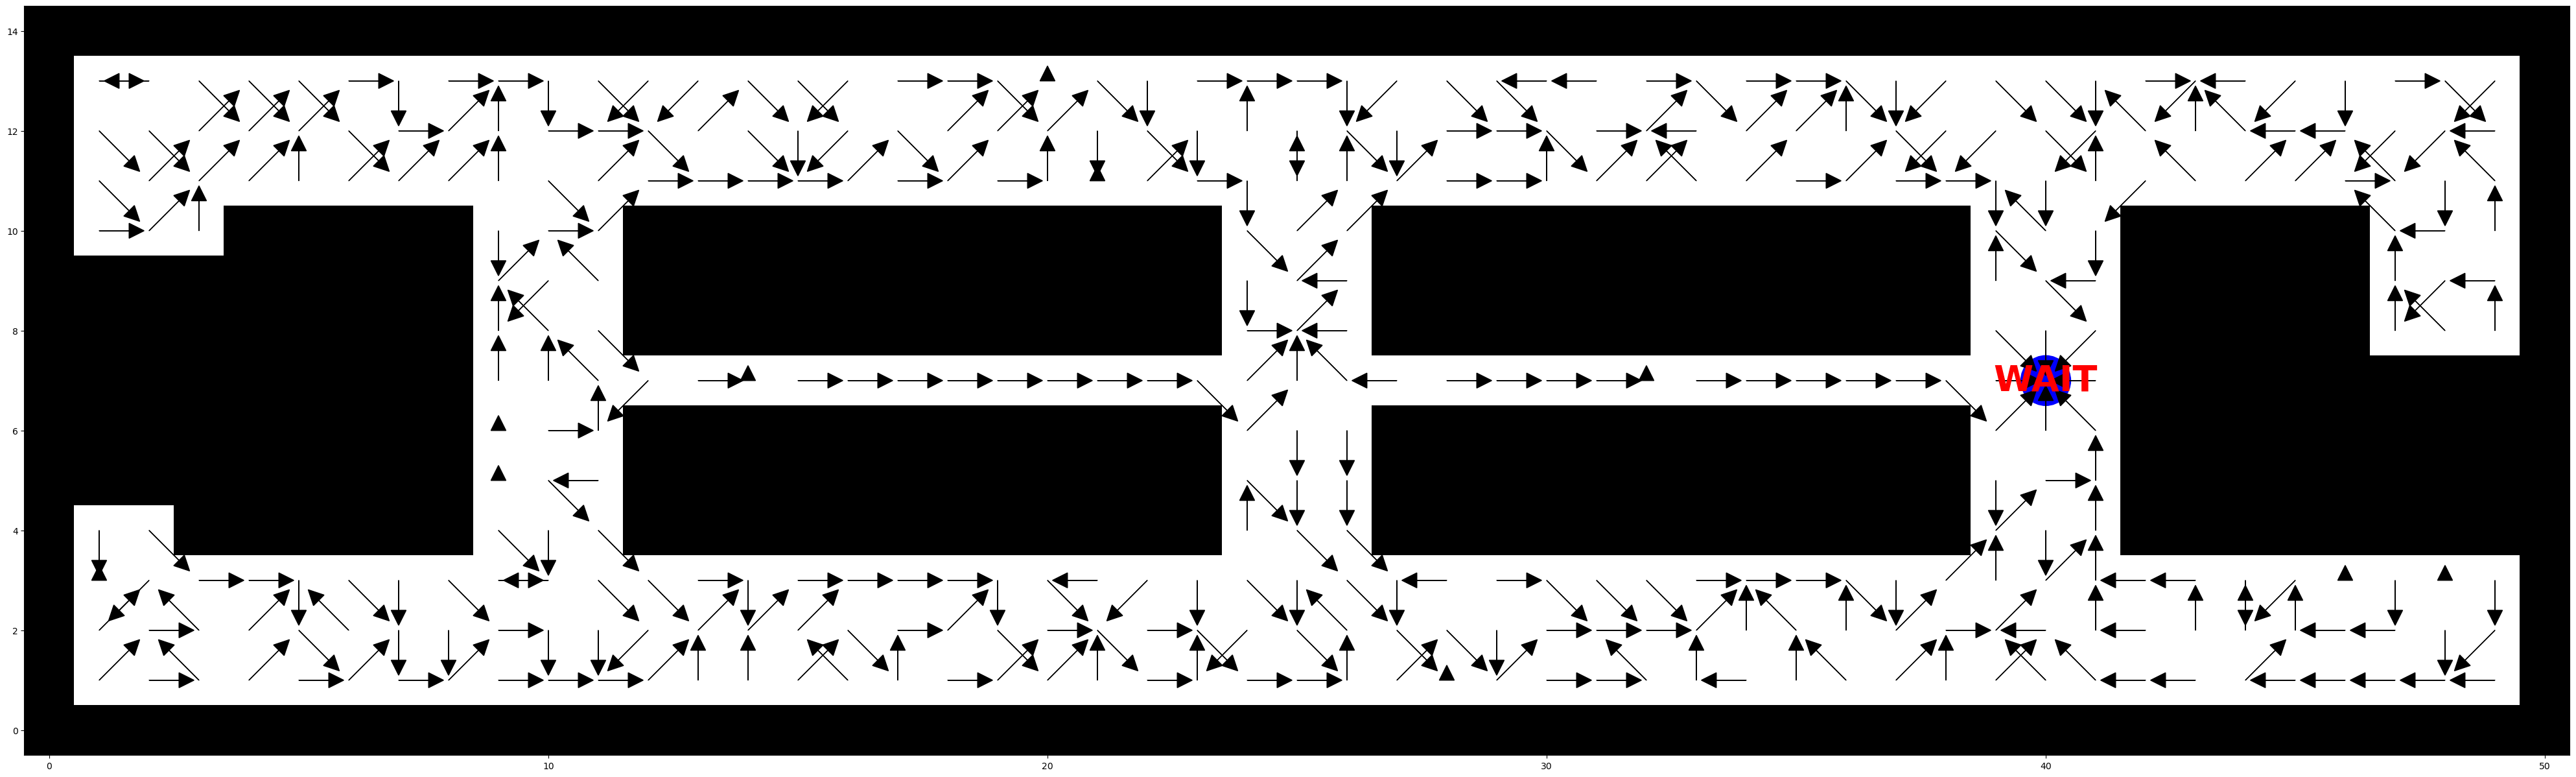

In [267]:
politica_sarsa = sarsa(mapa, destino, 1000000)
visualiza_politica(politica_sarsa)
